# End-to-end Machine Learning project

In this module, we will apply machine learning algorithm to predict median house values in Californian districts, given a number of features from these districts. We will learn several techniques:
* Visualize the data
* Handle missing values
* Transform numeric and categorical features
* Build a machine learning pipeline: From data processing, model training, and prediction

Typical machine learning pipeline includes the following components:
1. Data preprocessing (including data cleaning, making sure that the feature values are well defined; feature value standardization)
2. Feature engineering (What features are you going to use? Note that some features may just be noise and doesn't have good prediction ability. How about using a combination of features to increase your feature space?)
3. Run machine learning algorithms. In this module, we will mainly focus on linear regression. We can try KNN regression. In addition, we may try linear regression variants including batch SGD, mini-batch SGD, L1/L2 regularization, as exercises.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# define a random seed
random_seed = 42

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "house_price_prediction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import pandas as pd

# You can download the data from NYUclasses
housing = pd.read_csv("housing.csv")

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.shape

(20640, 10)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# See in Column 9, we have some categorical values. How to feed this into linear regression?
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# describe the numerical values
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


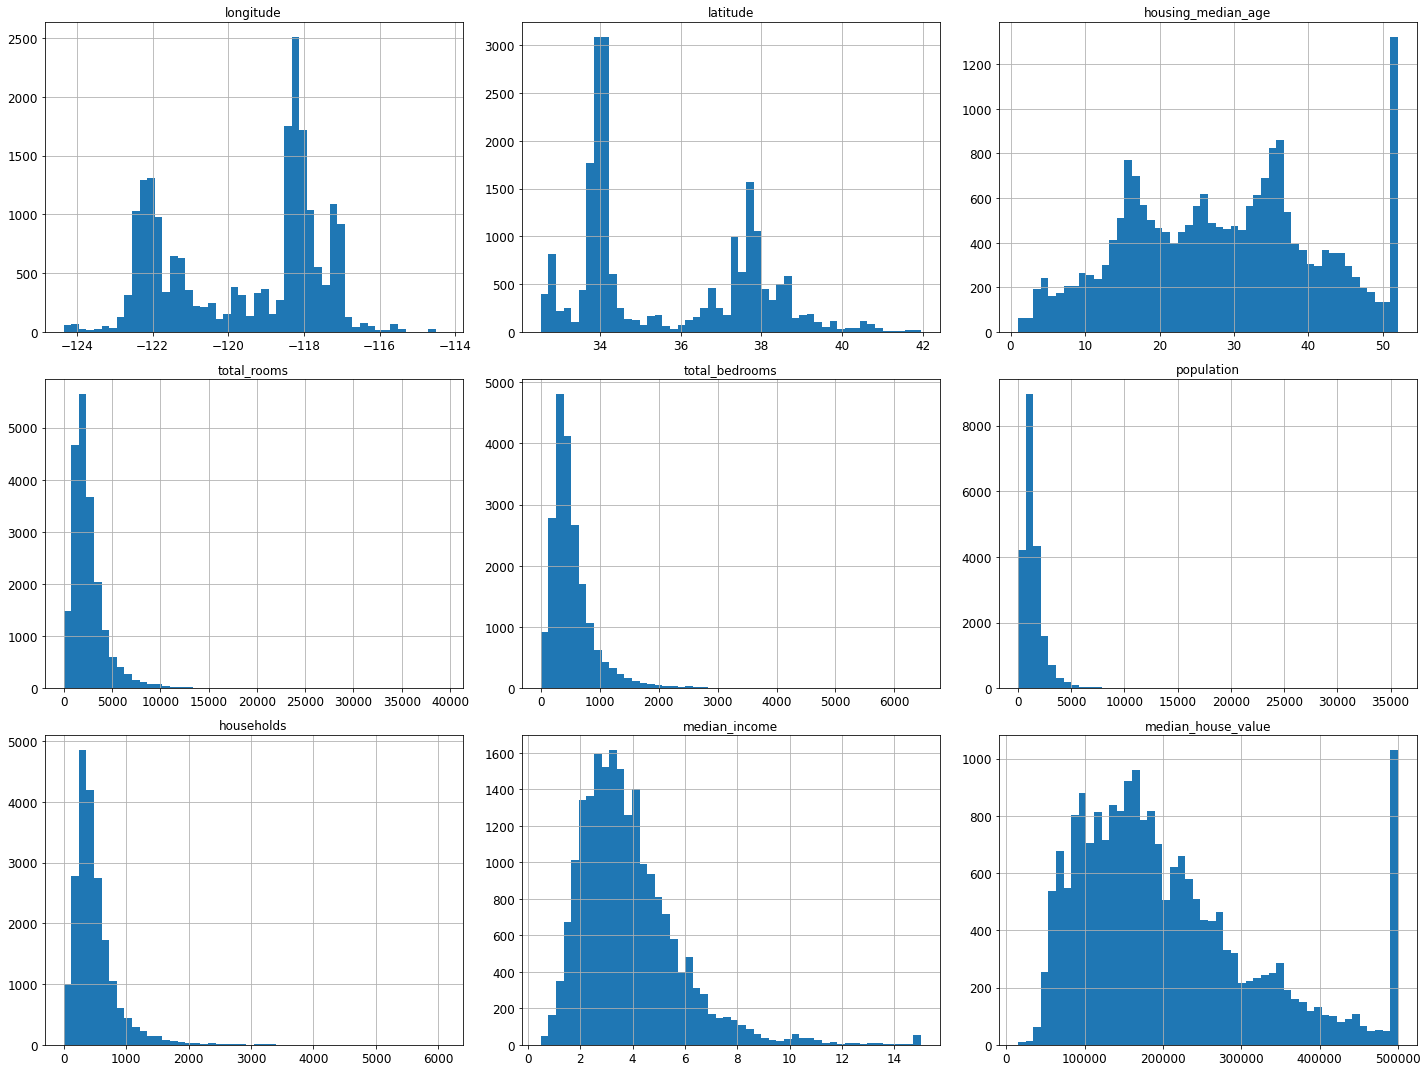

In [8]:
# Okay, let's plot some histogram to understand the distribution of various (numeric) features
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Notice that in this data set:
* Features such as "total_bedrooms" are the accumulated values of all households in an area. Some areas have more households than the other areas. We probably need to "massage" the feature values in some way (Data preprocessing step).
* Since our target is to predict the median house value, which features would be useful?

In [9]:
# to make this notebook's output identical at every run
np.random.seed(random_seed)

<AxesSubplot:>

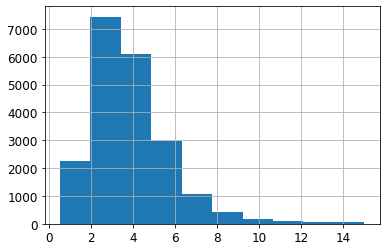

In [10]:
# Perhaps high income people will live in expensive house houses. Let's see 
housing["median_income"].hist()

In [11]:
# One trick: we can put feature values into categories by binning:
# Continuous feature can be converted into M discrete categories.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [12]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

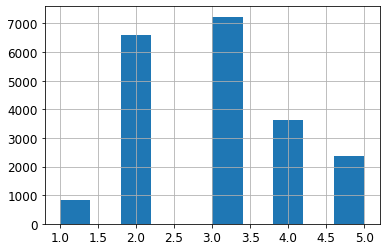

In [13]:
housing["income_cat"].hist()

In [14]:
housing.info()
housing.shape # notice that we added extra feature 'income_cat', derived from median_income

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


(20640, 11)

Now, let's divide our data set into train and test. This step is important because we need to estimate the performance of a machine learning algorithm using unseen data. Okay, let's do 8:2 split:

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Here we just perform 1 split. We can do K-split (aka K-fold train+test dataset for cross validation)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# we want to split the data so that income_cat distribution in train and test are similar to the population
for train_index, test_index in sss.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [18]:
# remove 'income_cat' column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [19]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


# Discover and visualize the data to gain insights

In [20]:
# visualize and feel the training data
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

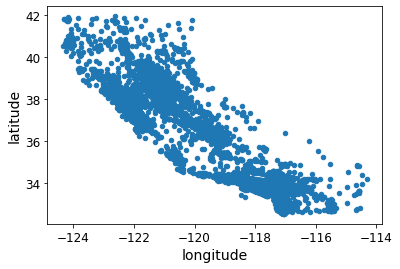

In [21]:
# The first try is to view where the houses are located
housing.plot(kind="scatter", x="longitude", y="latitude")
#save_fig("bad_visualization_plot")

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

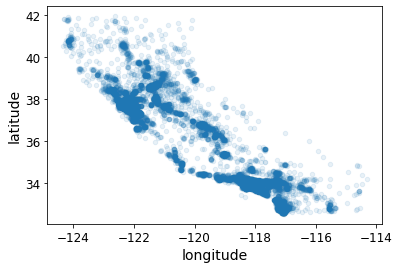

In [22]:
# Use alpha to highlight which parts of the regions are densely populated (Adjust transparency)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
#save_fig("better_visualization_plot")

Let's add some colors into the plot:

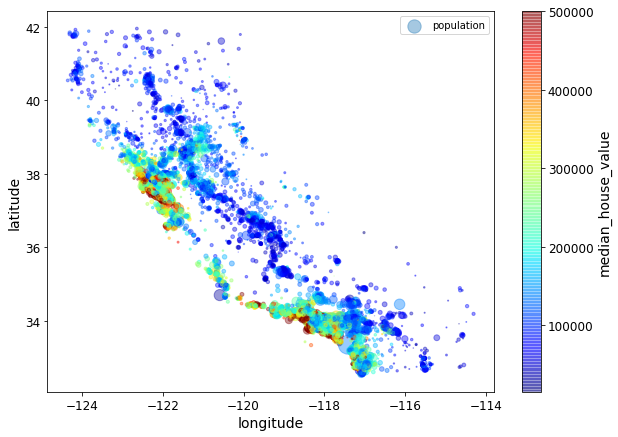

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
#save_fig("housing_prices_scatterplot")

Saving figure california_housing_prices_plot


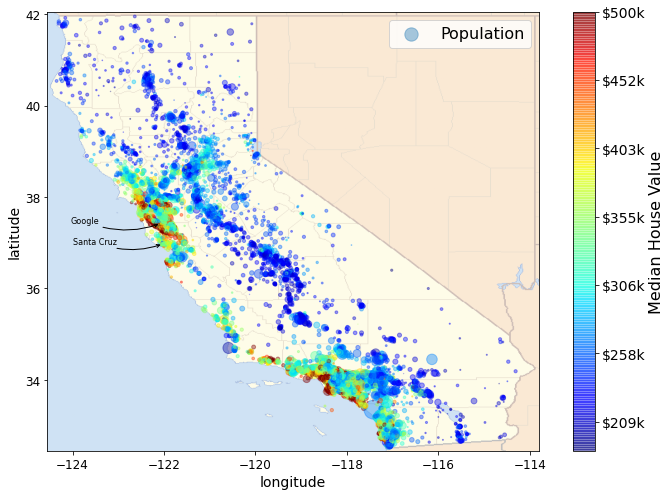

In [24]:
import matplotlib.image as mpimg
california_img=mpimg.imread("california.png")
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )

# add the California image
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))

# annotate location of Google
plt.annotate(r'Google',
                    xy=(-122.07882, 37.419857), xycoords='data',
                    xytext=(-90, 0), textcoords='offset points', fontsize=8,
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

# annotate location of Santa Cruz 
plt.annotate(r'Santa Cruz',
                    xy=(-122.030792, 36.974117), xycoords='data',
                    xytext=(-90, 0), textcoords='offset points', fontsize=8,
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

# TODO: annotate the location of the maximum bedroom per household
# plt.annotate(...)

# customize the color bar with a nicer scale
# Make 11 evenly-spaced tics
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)

# create a color bar
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)


# show the legend and the final plot
plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

# Exercise: Find the location where it has the maximum bedrooms per household. Annotate the location on the map above.

In [25]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


Let's compute the correlation for pair (feature, median_house_value), and sort the correlations. Correlation close to zero would imply two variables are not linearly correlated, which may be less useful for prediction.

In [26]:
corr_matrix = housing.corr()

In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


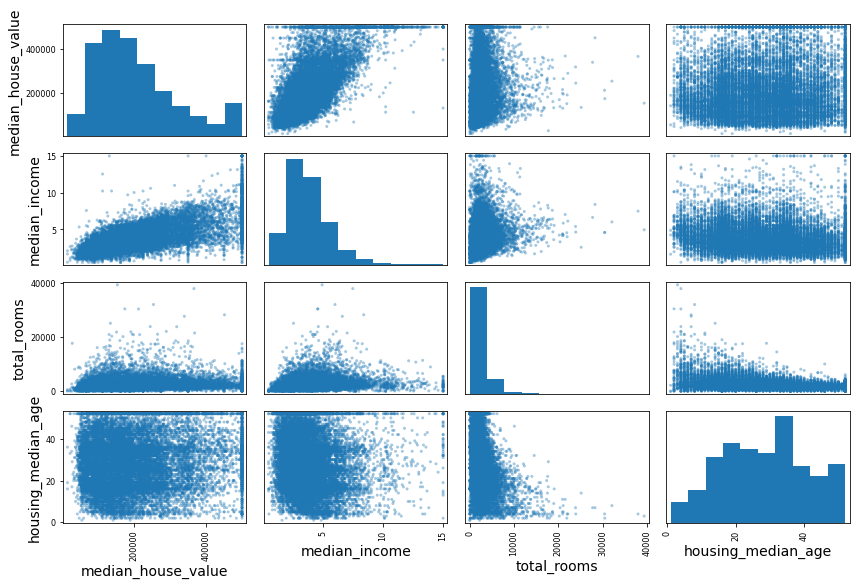

In [28]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

# let's check out the Top-4 correlated features and create the scatter plots, 4x4 plots (See non-diagonal plots)
# Diagonal plots are just the the histogram of the feature itself
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8), diagonal='hist', alpha=0.4)
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


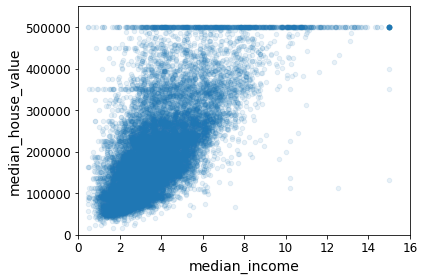

In [29]:
# This is the scatter plot of the Top correlated feature with the target median_house_value
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

From the plot, we do see some linearity between the median income and the target median house value.
This verifies the inituition that high-income household lives in a more expensive house :-).

In [30]:
# Let's do some normalization of features and re-do the correlation analysis
# This creates extra 3 columns, giving total columns of 13
housing["total_rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["total_bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [31]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_rooms_per_household,total_bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [32]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.687160
total_rooms_per_household    0.146285
total_rooms                  0.135097
housing_median_age           0.114110
households                   0.064506
total_bedrooms               0.047689
population_per_household    -0.021985
population                  -0.026920
longitude                   -0.047432
latitude                    -0.142724
total_bedrooms_per_room     -0.259984
Name: median_house_value, dtype: float64

The newly added per-houshold features are slightly more correlated than the unnormalized ones. Let's look at the scatter plot:

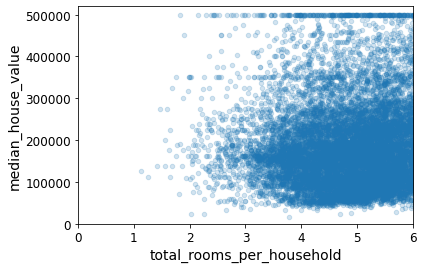

In [33]:
housing.plot(kind="scatter", x="total_rooms_per_household", y="median_house_value",
            alpha=0.2)
plt.axis([0, 6, 0, 520000])
plt.show()

# Exercise: Analyze log features
Try to create new attributes by:
1. taking log(.) over the promising features, such as rooms_per_household, bedrooms_per_room, and population_per_house. 
2. Analyze the feature correlations.
3. Plot the scatter plots on the new features versus the target median_house_value.
4. What's your finding?

In [34]:
# Let's take log of the values and re-do the correlation analysis
# TODO: You may create new columns below using np.log(.)
housing["log_total_rooms_per_household"] = np.log(housing["total_rooms_per_household"])
housing["log_total_bedrooms_per_room"] = np.log(housing["total_bedrooms_per_room"])
housing["log_population_per_household"] = np.log(housing["population_per_household"])

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value               1.000000
median_income                    0.687160
log_total_rooms_per_household    0.240375
total_rooms_per_household        0.146285
total_rooms                      0.135097
housing_median_age               0.114110
households                       0.064506
total_bedrooms                   0.047689
population_per_household        -0.021985
population                      -0.026920
longitude                       -0.047432
latitude                        -0.142724
log_population_per_household    -0.255649
total_bedrooms_per_room         -0.259984
log_total_bedrooms_per_room     -0.330378
Name: median_house_value, dtype: float64

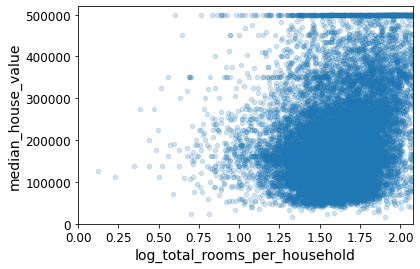

In [35]:
# TODO: Create scatter plot
housing.plot(kind="scatter", x="log_total_rooms_per_household", y="median_house_value",
            alpha=0.2)
plt.axis([0, np.log(8), 0, 520000])
plt.show()

Question: Can we conclude that the log features, which gives higher correlation, are more useful than the original ones? You guys find it out as an exercise. Remember to evaluate on the test set. What are the evaluation metrics by the way?

# Log Transform the numeric features

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'median_house_value'}>,
        <AxesSubplot:title={'center':'total_rooms_per_household'}>,
        <AxesSubplot:title={'center':'total_bedrooms_per_room'}>,
        <AxesSubplot:title={'center':'population_per_household'}>],
       [<AxesSubplot:title={'center':'log_total_rooms_per_household'}>,
        <AxesSubplot:title={'center':'log_total_bedrooms_per_room'}>,
        <AxesSubplot:title={'center':'log_population_per_household'}>,
        <AxesSubplot:>]], dtype=object)

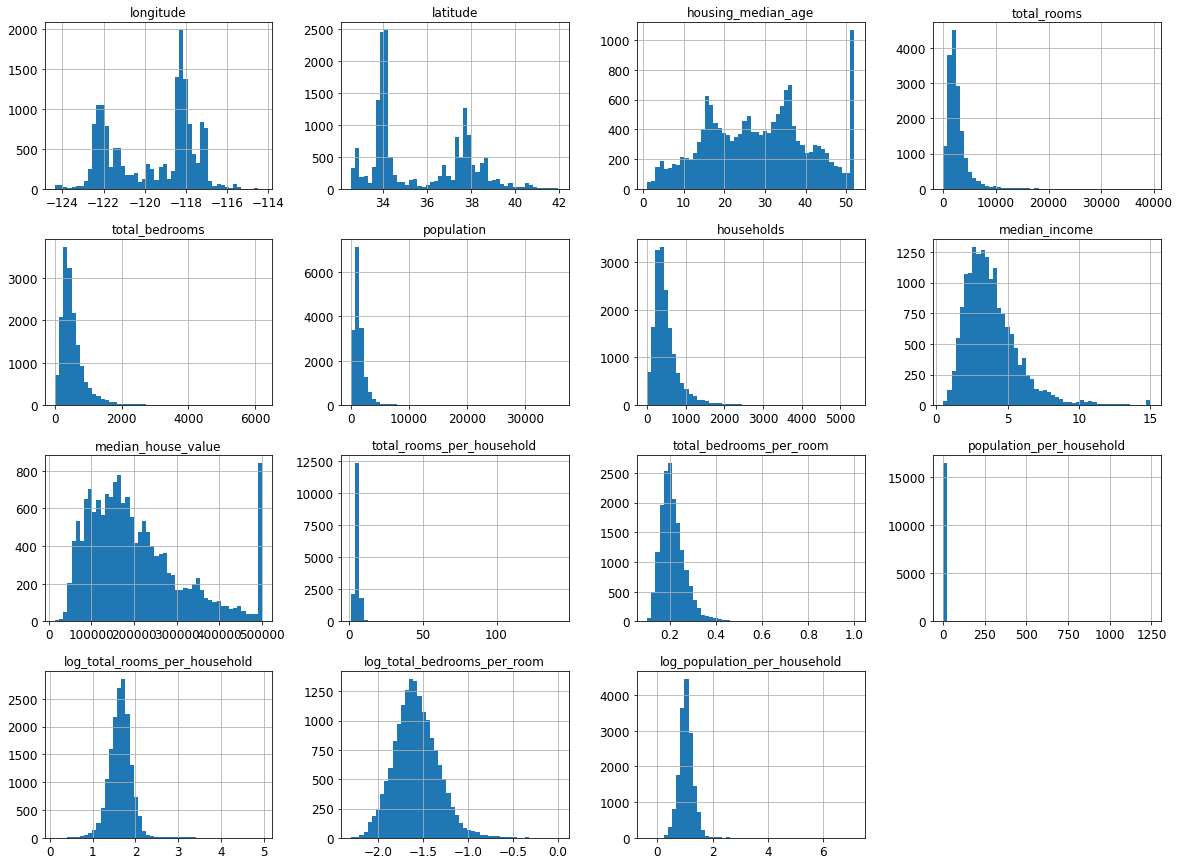

In [36]:
housing.hist(bins=50, figsize=(20,15))

In [37]:
# start from the training data
housing = strat_train_set.copy()
housing["total_rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["total_bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
df = housing.iloc[:,2:]
df.drop('ocean_proximity',axis = 1,inplace=True)
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_rooms_per_household,total_bedrooms_per_room,population_per_household
17606,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,4.625369,0.223852,2.094395
18632,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,6.008850,0.159057,2.707965
14650,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,4.225108,0.241291,2.025974
3230,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,5.232295,0.200866,4.135977
3555,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,4.505810,0.231341,3.047847


In [38]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)

df_log = transformer.transform(df)
df_log.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_rooms_per_household,total_bedrooms_per_room,population_per_household
17606,3.663562,7.358194,5.863631,6.566672,5.828946,1.309467,12.565846,1.727286,0.202003,1.129593
18632,2.708050,6.522093,4.691348,5.726848,4.736198,2.004368,12.738467,1.947174,0.147607,1.310483
14650,3.465736,7.577122,6.156979,6.842683,6.137727,1.351211,12.190456,1.653476,0.216152,1.107233
3230,3.258097,7.521859,5.918894,7.286876,5.869297,1.059144,10.742919,1.829745,0.183043,1.636270
3555,2.890372,8.793764,7.330405,8.402904,7.288928,1.394932,12.447060,1.705804,0.208104,1.398185


array([[<AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>],
       [<AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'median_house_value'}>,
        <AxesSubplot:title={'center':'total_rooms_per_household'}>,
        <AxesSubplot:title={'center':'total_bedrooms_per_room'}>],
       [<AxesSubplot:title={'center':'population_per_household'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

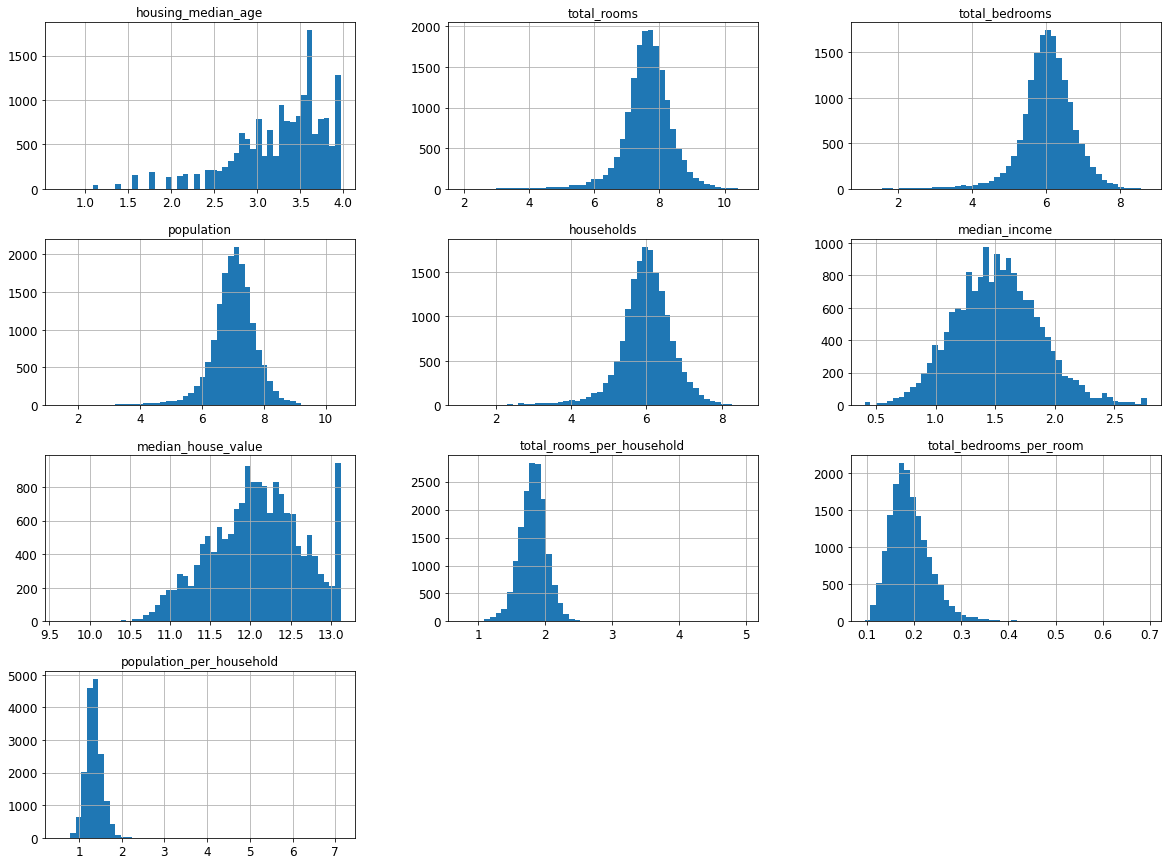

In [39]:
df_log.hist(bins=50, figsize=(20,15))

# Prepare the data for machine learning

Now, we are going to deal with samples with missing values. This usually happens in real-world scenario because we cannot gather all information.

Question: what are the common practices to deal with missing values?

In [40]:
# Prepare the train set
housing_labels = strat_train_set["median_house_value"].copy()
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set

# prepare the test set
housing_labels_test = strat_test_set["median_house_value"].copy()
housing_test = strat_test_set.drop("median_house_value", axis=1) # drop labels for test set

In [41]:
# Let's find out any columns (axis=1) that has null values
# For quick analysis, we just check the head() rows
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
print(sample_incomplete_rows.shape)
print(housing.shape)
sample_incomplete_rows

(5, 9)
(16512, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [42]:
# Option 1: remove rows that have Null values. The downside is that you may waste a lot of data.
# sample_incomplete_rows.dropna(subset=["total_bedrooms"]

In [43]:
# Option 2: Drop the feature (/column) total_bedrooms. Again, this is not ideal since we lose 1 feature column.
# sample_incomplete_rows.drop("total_bedrooms", axis=1)

In [44]:
# Option 3: Fill the missing values with some value. Here, we use median. 
# Actually, you can use mean/most frequent/constant. Check documentation
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

In [45]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [46]:
# Now, let's fill the missing value using SimpleImputer for the full dataset
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # default strategy is 'mean' (only applies to numeric value)

Remove the text attribute because median can only be calculated on numerical attributes:

In [47]:
# Let's remove this categorical feature for now. We will add it back later.
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])
housing_num.shape

(16512, 8)

In [48]:
# fit: It means taking the data frame and compute the strategy (median)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [49]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [50]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now, we can transform the data set:

In [51]:
# After fit(), we can transform the data by filling the median value
X = imputer.transform(housing_num)

In [52]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [53]:
housing_tr.loc[sample_incomplete_rows.index.values] # just a sanity check: We see the sample of incomplete rows now fills with values

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [54]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [55]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

# This also works, but in 2 steps
#ordinal_encoder.fit(housing_cat) # map the category into integer
#ordinal_encoder.transform(housing_cat) # transform the data

# We can use fit_transform to combine two steps into one:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [56]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [57]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [58]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [59]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [60]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        # HERE: X is the original data. Now, we create two columns:
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            # We add 3 column
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            # We add 2 column
            return np.c_[X, rooms_per_household, population_per_household]

# The nice thing to create a Transformer class is that we can add this process into a data preprocessing pipeline later.
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values) # notice that it takes a numpy array as input
housing_extra_attribs.shape

(16512, 11)

In [62]:
# Let's get back to pandas data frame from numpy
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)

# Now, check the last 2 new columns created using the transformer
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


### Log transform numeric values

In [63]:
# define a transformer for log transform
class LogTransform(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        # skip latitude and longitude
        first_two_col = X[:,0:2]
        rest_col = X[:,2:]      
        log_X = np.log1p(rest_col)
        return np.c_[first_two_col, log_X]

In [64]:
housing_extra_attribs.drop('ocean_proximity', axis=1, inplace=True)

In [65]:
to_transform = housing_extra_attribs.values.astype(float)

In [66]:
to_transform[:,2:]

array([[3.80000000e+01, 1.56800000e+03, 3.51000000e+02, ...,
        2.70420000e+00, 4.62536873e+00, 2.09439528e+00],
       [1.40000000e+01, 6.79000000e+02, 1.08000000e+02, ...,
        6.42140000e+00, 6.00884956e+00, 2.70796460e+00],
       [3.10000000e+01, 1.95200000e+03, 4.71000000e+02, ...,
        2.86210000e+00, 4.22510823e+00, 2.02597403e+00],
       ...,
       [9.00000000e+00, 4.85500000e+03, 8.72000000e+02, ...,
        3.27230000e+00, 6.34640523e+00, 2.74248366e+00],
       [3.10000000e+01, 1.96000000e+03, 3.80000000e+02, ...,
        4.06250000e+00, 5.50561798e+00, 3.80898876e+00],
       [5.20000000e+01, 3.09500000e+03, 6.82000000e+02, ...,
        3.57500000e+00, 4.84350548e+00, 1.98591549e+00]])

In [67]:
log_transformer = LogTransform()
log_transformed = log_transformer.transform(housing_extra_attribs.values.astype(float)) # notice that it takes a numpy array as input
log_transformed.shape

(16512, 10)

In [68]:
log_transformed = pd.DataFrame(
    log_transformed,
    columns=list(housing_extra_attribs.columns),
    index=housing.index)

# Now, check the values
log_transformed.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household
17606,-121.89,37.29,3.663562,7.358194,5.863631,6.566672,5.828946,1.309467,1.727286,1.129593
18632,-121.93,37.05,2.708050,6.522093,4.691348,5.726848,4.736198,2.004368,1.947174,1.310483
14650,-117.20,32.77,3.465736,7.577122,6.156979,6.842683,6.137727,1.351211,1.653476,1.107233
3230,-119.61,36.31,3.258097,7.521859,5.918894,7.286876,5.869297,1.059144,1.829745,1.636270
3555,-118.59,34.23,2.890372,8.793764,7.330405,8.402904,7.288928,1.394932,1.705804,1.398185


In [69]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


You may customize your own feature engineering class modules and add them to the data pipeline.

### Preprocessing using data pipeline

Now let's put things together and build a pipeline for preprocessing the numerical attributes:

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# (1) Impute missing value with median
# (2) Add extra attributes
# (3) Standardized numeric attribute to mean zero and stardard deviation of 1 (Standard Normal)
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)),
        # ('log_transform', LogTransform()),
        ('std_scaler', StandardScaler()),
    ])

# Now we call fit_transform to transform the training dataset
housing_num_tr = num_pipeline.fit_transform(housing_num)

Question: What's the purpose of standardization the feature values?

In [71]:
housing_num_tr.shape # notice that the result is a numpy object, not a pandas data frame!

(16512, 11)

In [72]:
from sklearn.compose import ColumnTransformer

# Combine the data preprocessing pipeline: 
# (1) Handle numeric features 
# (2) Handle categorical features
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

"""
This estimator allows different columns or column subsets of the input to be transformed separately 
and the features generated by each transformer will be concatenated to form a single feature space. 
This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms 
or transformations into a single transformer.
"""
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Fit + Transform data using the full_pipeline
housing_prepared = full_pipeline.fit_transform(housing)

# Transform the test set (Notice: We should just call the transform function, without fit(), otherwise it is cheating!)
housing_prepared_test = full_pipeline.transform(housing_test)

In [73]:
housing_prepared.shape # Now, we see that we have 8 (raw) + 3 (from num_pipeline) + 5 (1-hot features from the OneHotEncoder())

(16512, 16)

In [74]:
housing_prepared_test.shape

(4128, 16)

In [75]:
# visualize training data using dataframes
housing1 = pd.DataFrame(
    housing_prepared,
    columns=num_attribs+["rooms_per_household", "population_per_household", "bed_rooms_per_room"] + ["1hot_feature"] * 5)
housing1.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bed_rooms_per_room,1hot_feature,1hot_feature,1hot_feature,1hot_feature,1hot_feature
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


# Train a model using linear regression 

In [76]:
## tranform labels to log values
# housing_labels = np.log(housing_labels)
# housing_labels_test = np.log(housing_labels_test)

In [77]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

In [78]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [79]:
# let's try the full preprocessing pipeline on a few test instances
some_data = housing_test.iloc[:5]
some_labels = housing_labels_test.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Linear regression predictions:", lin_reg.predict(some_data_prepared))

Linear regression predictions: [424327.91587129 264520.09425443 228109.45155968 202824.58060687
 164265.4542434 ]


Compare against the actual values:

In [80]:
print("Labels:", list(some_labels))

Labels: [500001.0, 240300.0, 218200.0, 182100.0, 121300.0]


In [81]:
some_data_prepared

array([[ 0.59238393, -0.71074948,  0.02758786,  1.78838525,  1.16351084,
         0.68498857,  1.23217448,  2.31299771,  0.48830927, -0.07090847,
        -0.86820063,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.8571457 , -0.87445443,  0.8228579 ,  0.71842323,  0.29453231,
         0.22337528,  0.40973048,  0.38611673,  0.36310326, -0.04598303,
        -0.86028018,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.26268061, -0.66865392, -0.13146615,  0.8110161 ,  0.95417708,
         0.61865967,  1.00859747, -0.45340597, -0.17866074, -0.05936925,
        -0.01792937,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.71227605, -0.67333121,  1.85670895, -0.39128825, -0.55497332,
        -0.36013977, -0.46594615,  0.14500069,  0.04068081,  0.00561556,
        -0.64843204,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.94706479, -0.7341359 ,  0

In [82]:
from sklearn.metrics import mean_squared_error

housing_predictions_test = lin_reg.predict(housing_prepared_test)
lin_mse = mean_squared_error(housing_labels_test, housing_predictions_test)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

66911.98070857546

Mean absolute error is defined as:
    
$
\text{MAE} = \frac{1}{N} \sum_{i=1}^N |y_i - f(X_i;\Theta)|
$

In [83]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels_test, housing_predictions_test)
lin_mae

49228.61566495419

# Check the resulting feature weights
Usually, higher the feature weight, more importance is the feature. Feature weights very close to zero would imply that these features may just be noise. However, we better trust the performance over the validation set.

In [84]:
print(lin_reg.coef_)
print(lin_reg.intercept_)

[-55650.4116403  -56716.45236929  13732.83841856  -1933.1277138
   7330.04062103 -45708.26306673  45455.47519691  74714.39134154
   6605.12802802   1042.95709453   9249.75886697 -18016.52432168
 -55219.15208555 110357.78363967 -22479.84008184 -14642.2671506 ]
236914.99732815975


# Exercise: Predict the log value of median house price
In this case, the loss function would become:

$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (\log y_i - f(X_i;\Theta))^2
$

Would predicting the logarithm of median house price be easier/same/more difficult?

# Exercise: Tranform numeric features with log(.) 
Insert this log(.) Transform into the data processing pipeline. Train the model and report test RMSE and MAE on the training and test sets.

# Exercise: Try different model
Try fitting the model and predict on the test set, using:
* sklearn.neighbors.KNeighborsRegressor: KNN regression
* linear_model.Ridge: Linear least squares with l2 regularization
* linear_model.SGDRegressor: Linear regression with SGD
* Report RMSE, and MAE on the training and test sets

# A full pipeline with both preparation and prediction

In [85]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([424327.91587129, 264520.09425443, 228109.45155968, 202824.58060687,
       164265.4542434 ])

# Model persistence using joblib

In [86]:
my_model = full_pipeline_with_predictor

In [87]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF